In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 17:07 - loss: 0.0817 - STD: 2.0438e-04 - MAE: 0.2706

  8/793 [..............................] - ETA: 5s - loss: 0.0290 - STD: 2.3949e-04 - MAE: 0.1353   

 15/793 [..............................] - ETA: 5s - loss: 0.0242 - STD: 1.5718e-04 - MAE: 0.1210

 21/793 [..............................] - ETA: 6s - loss: 0.0205 - STD: 1.3326e-04 - MAE: 0.1112

 27/793 [>.............................] - ETA: 6s - loss: 0.0183 - STD: 1.2330e-04 - MAE: 0.1053

 33/793 [>.............................] - ETA: 6s - loss: 0.0169 - STD: 1.2124e-04 - MAE: 0.0999

 39/793 [>.............................] - ETA: 6s - loss: 0.0157 - STD: 1.2440e-04 - MAE: 0.0960

 45/793 [>.............................] - ETA: 6s - loss: 0.0149 - STD: 1.3137e-04 - MAE: 0.0936

 51/793 [>.............................] - ETA: 6s - loss: 0.0142 - STD: 1.3992e-04 - MAE: 0.0914

 57/793 [=>............................] - ETA: 6s - loss: 0.0137 - STD: 1.5019e-04 - MAE: 0.0896

 63/793 [=>............................] - ETA: 6s - loss: 0.0132 - STD: 1.6307e-04 - MAE: 0.0883

 69/793 [=>............................] - ETA: 6s - loss: 0.0129 - STD: 1.7890e-04 - MAE: 0.0872

 75/793 [=>............................] - ETA: 6s - loss: 0.0126 - STD: 1.9668e-04 - MAE: 0.0863

 81/793 [==>...........................] - ETA: 6s - loss: 0.0124 - STD: 2.1940e-04 - MAE: 0.0855

 88/793 [==>...........................] - ETA: 6s - loss: 0.0121 - STD: 2.5060e-04 - MAE: 0.0847

 94/793 [==>...........................] - ETA: 6s - loss: 0.0119 - STD: 2.8424e-04 - MAE: 0.0841

100/793 [==>...........................] - ETA: 6s - loss: 0.0118 - STD: 3.2669e-04 - MAE: 0.0836

106/793 [===>..........................] - ETA: 5s - loss: 0.0116 - STD: 3.8110e-04 - MAE: 0.0832

112/793 [===>..........................] - ETA: 5s - loss: 0.0115 - STD: 4.4934e-04 - MAE: 0.0828

118/793 [===>..........................] - ETA: 5s - loss: 0.0114 - STD: 5.4332e-04 - MAE: 0.0825

124/793 [===>..........................] - ETA: 5s - loss: 0.0113 - STD: 6.6654e-04 - MAE: 0.0821

130/793 [===>..........................] - ETA: 5s - loss: 0.0112 - STD: 8.3924e-04 - MAE: 0.0818

136/793 [====>.........................] - ETA: 5s - loss: 0.0111 - STD: 0.0011 - MAE: 0.0814    

142/793 [====>.........................] - ETA: 5s - loss: 0.0110 - STD: 0.0014 - MAE: 0.0810

148/793 [====>.........................] - ETA: 5s - loss: 0.0109 - STD: 0.0019 - MAE: 0.0807

154/793 [====>.........................] - ETA: 5s - loss: 0.0107 - STD: 0.0026 - MAE: 0.0803

160/793 [=====>........................] - ETA: 5s - loss: 0.0106 - STD: 0.0035 - MAE: 0.0800

166/793 [=====>........................] - ETA: 5s - loss: 0.0105 - STD: 0.0045 - MAE: 0.0795

172/793 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0056 - MAE: 0.0791

178/793 [=====>........................] - ETA: 5s - loss: 0.0103 - STD: 0.0067 - MAE: 0.0787

184/793 [=====>........................] - ETA: 5s - loss: 0.0102 - STD: 0.0078 - MAE: 0.0782

190/793 [======>.......................] - ETA: 5s - loss: 0.0101 - STD: 0.0089 - MAE: 0.0778

196/793 [======>.......................] - ETA: 5s - loss: 0.0100 - STD: 0.0098 - MAE: 0.0775

202/793 [======>.......................] - ETA: 5s - loss: 0.0099 - STD: 0.0108 - MAE: 0.0771

208/793 [======>.......................] - ETA: 5s - loss: 0.0098 - STD: 0.0118 - MAE: 0.0768

215/793 [=======>......................] - ETA: 5s - loss: 0.0097 - STD: 0.0128 - MAE: 0.0764

221/793 [=======>......................] - ETA: 4s - loss: 0.0097 - STD: 0.0137 - MAE: 0.0760

228/793 [=======>......................] - ETA: 4s - loss: 0.0096 - STD: 0.0147 - MAE: 0.0756

237/793 [=======>......................] - ETA: 4s - loss: 0.0094 - STD: 0.0158 - MAE: 0.0751

244/793 [========>.....................] - ETA: 4s - loss: 0.0094 - STD: 0.0166 - MAE: 0.0747

250/793 [========>.....................] - ETA: 4s - loss: 0.0093 - STD: 0.0174 - MAE: 0.0744

257/793 [========>.....................] - ETA: 4s - loss: 0.0092 - STD: 0.0183 - MAE: 0.0740

264/793 [========>.....................] - ETA: 4s - loss: 0.0091 - STD: 0.0192 - MAE: 0.0736

271/793 [=========>....................] - ETA: 4s - loss: 0.0090 - STD: 0.0201 - MAE: 0.0732

277/793 [=========>....................] - ETA: 4s - loss: 0.0090 - STD: 0.0209 - MAE: 0.0728

283/793 [=========>....................] - ETA: 4s - loss: 0.0089 - STD: 0.0216 - MAE: 0.0725

290/793 [=========>....................] - ETA: 4s - loss: 0.0088 - STD: 0.0225 - MAE: 0.0721

296/793 [==========>...................] - ETA: 4s - loss: 0.0087 - STD: 0.0231 - MAE: 0.0719

302/793 [==========>...................] - ETA: 4s - loss: 0.0087 - STD: 0.0238 - MAE: 0.0716

309/793 [==========>...................] - ETA: 4s - loss: 0.0086 - STD: 0.0246 - MAE: 0.0712

315/793 [==========>...................] - ETA: 4s - loss: 0.0085 - STD: 0.0252 - MAE: 0.0709

321/793 [===========>..................] - ETA: 4s - loss: 0.0085 - STD: 0.0259 - MAE: 0.0706

328/793 [===========>..................] - ETA: 3s - loss: 0.0084 - STD: 0.0266 - MAE: 0.0702

337/793 [===========>..................] - ETA: 3s - loss: 0.0083 - STD: 0.0275 - MAE: 0.0698

345/793 [============>.................] - ETA: 3s - loss: 0.0082 - STD: 0.0283 - MAE: 0.0694

351/793 [============>.................] - ETA: 3s - loss: 0.0082 - STD: 0.0289 - MAE: 0.0691

357/793 [============>.................] - ETA: 3s - loss: 0.0081 - STD: 0.0294 - MAE: 0.0689

363/793 [============>.................] - ETA: 3s - loss: 0.0081 - STD: 0.0300 - MAE: 0.0686

369/793 [============>.................] - ETA: 3s - loss: 0.0080 - STD: 0.0305 - MAE: 0.0683

375/793 [=============>................] - ETA: 3s - loss: 0.0080 - STD: 0.0311 - MAE: 0.0681

381/793 [=============>................] - ETA: 3s - loss: 0.0079 - STD: 0.0316 - MAE: 0.0678

387/793 [=============>................] - ETA: 3s - loss: 0.0079 - STD: 0.0321 - MAE: 0.0677

393/793 [=============>................] - ETA: 3s - loss: 0.0078 - STD: 0.0325 - MAE: 0.0674

399/793 [==============>...............] - ETA: 3s - loss: 0.0078 - STD: 0.0330 - MAE: 0.0672

405/793 [==============>...............] - ETA: 3s - loss: 0.0077 - STD: 0.0335 - MAE: 0.0669

411/793 [==============>...............] - ETA: 3s - loss: 0.0077 - STD: 0.0340 - MAE: 0.0667

417/793 [==============>...............] - ETA: 3s - loss: 0.0076 - STD: 0.0344 - MAE: 0.0665

423/793 [===============>..............] - ETA: 3s - loss: 0.0076 - STD: 0.0348 - MAE: 0.0663

430/793 [===============>..............] - ETA: 3s - loss: 0.0076 - STD: 0.0352 - MAE: 0.0661

437/793 [===============>..............] - ETA: 3s - loss: 0.0075 - STD: 0.0356 - MAE: 0.0659

443/793 [===============>..............] - ETA: 2s - loss: 0.0075 - STD: 0.0360 - MAE: 0.0657

449/793 [===============>..............] - ETA: 2s - loss: 0.0075 - STD: 0.0364 - MAE: 0.0655

455/793 [================>.............] - ETA: 2s - loss: 0.0074 - STD: 0.0368 - MAE: 0.0653

461/793 [================>.............] - ETA: 2s - loss: 0.0074 - STD: 0.0372 - MAE: 0.0651

468/793 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.0377 - MAE: 0.0649

475/793 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.0381 - MAE: 0.0647

481/793 [=================>............] - ETA: 2s - loss: 0.0072 - STD: 0.0385 - MAE: 0.0645

487/793 [=================>............] - ETA: 2s - loss: 0.0072 - STD: 0.0389 - MAE: 0.0643

493/793 [=================>............] - ETA: 2s - loss: 0.0072 - STD: 0.0392 - MAE: 0.0642

499/793 [=================>............] - ETA: 2s - loss: 0.0072 - STD: 0.0395 - MAE: 0.0640

505/793 [==================>...........] - ETA: 2s - loss: 0.0071 - STD: 0.0398 - MAE: 0.0639

511/793 [==================>...........] - ETA: 2s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0637

517/793 [==================>...........] - ETA: 2s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0635

523/793 [==================>...........] - ETA: 2s - loss: 0.0070 - STD: 0.0408 - MAE: 0.0634

529/793 [===================>..........] - ETA: 2s - loss: 0.0070 - STD: 0.0411 - MAE: 0.0632

535/793 [===================>..........] - ETA: 2s - loss: 0.0070 - STD: 0.0414 - MAE: 0.0631

542/793 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0417 - MAE: 0.0629

548/793 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0628

554/793 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0626

560/793 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0425 - MAE: 0.0624

566/793 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0428 - MAE: 0.0623

572/793 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0621

578/793 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0434 - MAE: 0.0620

584/793 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0436 - MAE: 0.0619

590/793 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0439 - MAE: 0.0617

596/793 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0441 - MAE: 0.0616

602/793 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0444 - MAE: 0.0614

608/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0446 - MAE: 0.0613

614/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0449 - MAE: 0.0612

617/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0450 - MAE: 0.0611

625/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0453 - MAE: 0.0609

631/793 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0455 - MAE: 0.0608

637/793 [=======================>......] - ETA: 1s - loss: 0.0065 - STD: 0.0458 - MAE: 0.0607

643/793 [=======================>......] - ETA: 1s - loss: 0.0065 - STD: 0.0460 - MAE: 0.0606

649/793 [=======================>......] - ETA: 1s - loss: 0.0065 - STD: 0.0462 - MAE: 0.0604

655/793 [=======================>......] - ETA: 1s - loss: 0.0064 - STD: 0.0465 - MAE: 0.0603

661/793 [========================>.....] - ETA: 1s - loss: 0.0064 - STD: 0.0467 - MAE: 0.0602

667/793 [========================>.....] - ETA: 1s - loss: 0.0064 - STD: 0.0469 - MAE: 0.0601

673/793 [========================>.....] - ETA: 1s - loss: 0.0064 - STD: 0.0471 - MAE: 0.0600

679/793 [========================>.....] - ETA: 1s - loss: 0.0064 - STD: 0.0473 - MAE: 0.0599

685/793 [========================>.....] - ETA: 1s - loss: 0.0063 - STD: 0.0475 - MAE: 0.0598

691/793 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0477 - MAE: 0.0597

698/793 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0479 - MAE: 0.0595

704/793 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0481 - MAE: 0.0594

710/793 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0483 - MAE: 0.0593

716/793 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0485 - MAE: 0.0592

722/793 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0487 - MAE: 0.0591

728/793 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0488 - MAE: 0.0590

734/793 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0490 - MAE: 0.0589

740/793 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0492 - MAE: 0.0588

746/793 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0494 - MAE: 0.0587

752/793 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0495 - MAE: 0.0586

758/793 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0497 - MAE: 0.0586

764/793 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0499 - MAE: 0.0585

770/793 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0500 - MAE: 0.0584

776/793 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0502 - MAE: 0.0583

782/793 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0504 - MAE: 0.0582

788/793 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0505 - MAE: 0.0581

793/793 [==============================] - 10s 10ms/step - loss: 0.0060 - STD: 0.0507 - MAE: 0.0580 - val_loss: 0.0036 - val_STD: 0.0532 - val_MAE: 0.0432


Epoch 2/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0036 - STD: 0.0662 - MAE: 0.0437

  6/793 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0682 - MAE: 0.0463 

 12/793 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0701 - MAE: 0.0463

 17/793 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0464

 23/793 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0698 - MAE: 0.0465

 29/793 [>.............................] - ETA: 7s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0472

 35/793 [>.............................] - ETA: 7s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

 42/793 [>.............................] - ETA: 7s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0471

 48/793 [>.............................] - ETA: 7s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0469

 54/793 [=>............................] - ETA: 6s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0468

 60/793 [=>............................] - ETA: 6s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0469

 66/793 [=>............................] - ETA: 6s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0468

 72/793 [=>............................] - ETA: 6s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0468

 78/793 [=>............................] - ETA: 6s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0469

 83/793 [==>...........................] - ETA: 6s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0468

 89/793 [==>...........................] - ETA: 6s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0468

 95/793 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

101/793 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

107/793 [===>..........................] - ETA: 6s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

113/793 [===>..........................] - ETA: 6s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

120/793 [===>..........................] - ETA: 6s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

127/793 [===>..........................] - ETA: 6s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

133/793 [====>.........................] - ETA: 6s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0464

139/793 [====>.........................] - ETA: 5s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

145/793 [====>.........................] - ETA: 5s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0463

151/793 [====>.........................] - ETA: 5s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

156/793 [====>.........................] - ETA: 5s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

162/793 [=====>........................] - ETA: 5s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0464

168/793 [=====>........................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0464

174/793 [=====>........................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0464

180/793 [=====>........................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0464

186/793 [======>.......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

192/793 [======>.......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

198/793 [======>.......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

204/793 [======>.......................] - ETA: 5s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

210/793 [======>.......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

216/793 [=======>......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

224/793 [=======>......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

232/793 [=======>......................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

238/793 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0463

244/793 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

250/793 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

256/793 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0463

262/793 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0463

268/793 [=========>....................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0462

274/793 [=========>....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0463

280/793 [=========>....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

286/793 [=========>....................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

292/793 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

298/793 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

304/793 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

310/793 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0462

316/793 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0462

322/793 [===========>..................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0462

328/793 [===========>..................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0461

333/793 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

339/793 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

345/793 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

351/793 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

357/793 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

363/793 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

369/793 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

375/793 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

381/793 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

387/793 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

393/793 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

399/793 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

405/793 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

411/793 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

417/793 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

423/793 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

429/793 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

435/793 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

441/793 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

447/793 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

453/793 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

459/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

465/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

471/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

477/793 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

483/793 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

489/793 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

495/793 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

501/793 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

507/793 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

513/793 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

519/793 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

525/793 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

531/793 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

537/793 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

543/793 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

549/793 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

555/793 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

561/793 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

567/793 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0455

573/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0455

579/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0455

585/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

591/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

597/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

603/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

609/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

615/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

622/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

628/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

634/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

640/793 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

646/793 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

652/793 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

658/793 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

664/793 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

670/793 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

676/793 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

682/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

688/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

694/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

700/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

706/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

712/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

718/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

724/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

730/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

736/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

742/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

748/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

754/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

760/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

766/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

772/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

778/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

784/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

790/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

793/793 [==============================] - 8s 9ms/step - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453 - val_loss: 0.0031 - val_STD: 0.0581 - val_MAE: 0.0405


Epoch 3/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0425

  7/793 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0448 

 13/793 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

 19/793 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

 25/793 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

 31/793 [>.............................] - ETA: 6s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

 38/793 [>.............................] - ETA: 6s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

 45/793 [>.............................] - ETA: 6s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

 51/793 [>.............................] - ETA: 6s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 57/793 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

 63/793 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

 69/793 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

 75/793 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

 82/793 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

 88/793 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

 95/793 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

101/793 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

108/793 [===>..........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

114/793 [===>..........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

120/793 [===>..........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

128/793 [===>..........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

134/793 [====>.........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

140/793 [====>.........................] - ETA: 5s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

147/793 [====>.........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

153/793 [====>.........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

159/793 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

165/793 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

171/793 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

177/793 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

183/793 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

189/793 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

195/793 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

201/793 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

208/793 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

214/793 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

220/793 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

228/793 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

236/793 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

242/793 [========>.....................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

248/793 [========>.....................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

254/793 [========>.....................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

260/793 [========>.....................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

266/793 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

272/793 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

278/793 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

284/793 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

290/793 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

296/793 [==========>...................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

302/793 [==========>...................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

308/793 [==========>...................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

314/793 [==========>...................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

320/793 [===========>..................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

326/793 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

332/793 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

338/793 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

344/793 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

350/793 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

356/793 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

362/793 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

368/793 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

374/793 [=============>................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

380/793 [=============>................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

387/793 [=============>................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

393/793 [=============>................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

399/793 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

405/793 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

411/793 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

417/793 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

423/793 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

429/793 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

436/793 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

442/793 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

448/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

454/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

460/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

466/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

472/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

478/793 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

485/793 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

492/793 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

499/793 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

505/793 [==================>...........] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

511/793 [==================>...........] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

517/793 [==================>...........] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

523/793 [==================>...........] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

530/793 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

536/793 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

542/793 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

548/793 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

554/793 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

560/793 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

566/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

572/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

578/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

584/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

590/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

596/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

602/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

608/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

614/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

620/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

626/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

632/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

638/793 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

644/793 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

650/793 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

656/793 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

662/793 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

668/793 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

674/793 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

680/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

686/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

693/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

699/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

705/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

711/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

717/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

723/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

729/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

735/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

741/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

747/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

753/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

759/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

765/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

771/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

778/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

784/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

790/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

793/793 [==============================] - 7s 9ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433 - val_loss: 0.0033 - val_STD: 0.0551 - val_MAE: 0.0405


Epoch 4/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0422

  7/793 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0436 

 13/793 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0434

 19/793 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

 25/793 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

 31/793 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 37/793 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

 43/793 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

 49/793 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 55/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

 61/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

 67/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

 73/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

 78/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 84/793 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

 90/793 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 96/793 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

102/793 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

108/793 [===>..........................] - ETA: 6s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

114/793 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

120/793 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

126/793 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

133/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

140/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

146/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

152/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

158/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

164/793 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

170/793 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

176/793 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

182/793 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

188/793 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

194/793 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

200/793 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

205/793 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

211/793 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

217/793 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

223/793 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

231/793 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

239/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

245/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

251/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

257/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

263/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

268/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

274/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

280/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

287/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

293/793 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

299/793 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

305/793 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

311/793 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

317/793 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

323/793 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

329/793 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

335/793 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

341/793 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

347/793 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

353/793 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

359/793 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

365/793 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

371/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

377/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

383/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

389/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

395/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

401/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

407/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

413/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

419/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

425/793 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

431/793 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

437/793 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

443/793 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

449/793 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

455/793 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

461/793 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

467/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

473/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

479/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

485/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

491/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

497/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

503/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

509/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

515/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

521/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

527/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

533/793 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

539/793 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

545/793 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

551/793 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

557/793 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

563/793 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

569/793 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

574/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

580/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

585/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

591/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

596/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

602/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

608/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

614/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

620/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

626/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

632/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

638/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

644/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

650/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

656/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

662/793 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

668/793 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

674/793 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

680/793 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

686/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

692/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

698/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

704/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

710/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

716/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

722/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

728/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

734/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

740/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

746/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

752/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

758/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

764/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

771/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

777/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

783/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

789/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

793/793 [==============================] - 8s 10ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422 - val_loss: 0.0028 - val_STD: 0.0604 - val_MAE: 0.0385


Epoch 5/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0412

  6/793 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0426 

 12/793 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0751 - MAE: 0.0419

 18/793 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

 23/793 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

 29/793 [>.............................] - ETA: 7s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 35/793 [>.............................] - ETA: 7s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

 41/793 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0421

 47/793 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

 53/793 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 59/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

 65/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0421

 71/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

 77/793 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

 84/793 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

 90/793 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 96/793 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

104/793 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

111/793 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

116/793 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

122/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0423

128/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0423

134/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0423

139/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0422

145/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0422

151/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0421

157/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0421

163/793 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0421

169/793 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0421

175/793 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

181/793 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

187/793 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

193/793 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

200/793 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

208/793 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

215/793 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

221/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

227/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

233/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

239/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

245/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

251/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

257/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

264/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

270/793 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

276/793 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

282/793 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

288/793 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

294/793 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

300/793 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

306/793 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

312/793 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

318/793 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

324/793 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

330/793 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

336/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

342/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

348/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

354/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

361/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

367/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

373/793 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

379/793 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

385/793 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

391/793 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

397/793 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

404/793 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

410/793 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

416/793 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

423/793 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

430/793 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

436/793 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

443/793 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

449/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

455/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

462/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

468/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

474/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

480/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

487/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

493/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

500/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

506/793 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

512/793 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

518/793 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

524/793 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

530/793 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

536/793 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

543/793 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

549/793 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

555/793 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

561/793 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

567/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

573/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

580/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

592/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

598/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

605/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

611/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

617/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

624/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

630/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

636/793 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

642/793 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

648/793 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

654/793 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

661/793 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

667/793 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

673/793 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

679/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

685/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

691/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

697/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

703/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

709/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

715/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

721/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

727/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

733/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

739/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

745/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

751/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

757/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

763/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

769/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

775/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

781/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

787/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

793/793 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

793/793 [==============================] - 7s 9ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0616 - val_MAE: 0.0382


Epoch 6/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

  7/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401 

 13/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 19/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 25/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 31/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

 37/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 43/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 48/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 54/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 60/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

 66/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

 72/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 78/793 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

 84/793 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

 90/793 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

 96/793 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

102/793 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

107/793 [===>..........................] - ETA: 6s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

113/793 [===>..........................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

121/793 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

128/793 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

134/793 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

140/793 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

146/793 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

152/793 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

158/793 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

164/793 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

170/793 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

176/793 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

182/793 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

188/793 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

194/793 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

200/793 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

206/793 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

213/793 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

221/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

229/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

235/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

241/793 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

247/793 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

253/793 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

259/793 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

265/793 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

271/793 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

277/793 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

283/793 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

289/793 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

295/793 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

301/793 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

307/793 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

314/793 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

320/793 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

326/793 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

332/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

339/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

345/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

351/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

357/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

363/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

369/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

375/793 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

381/793 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

387/793 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

393/793 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

399/793 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

406/793 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

412/793 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

418/793 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

424/793 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

431/793 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

437/793 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

443/793 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

449/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

456/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

462/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

468/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

474/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

480/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

486/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

492/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

498/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

504/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

511/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

517/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

523/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

529/793 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

535/793 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

541/793 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

547/793 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

553/793 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

560/793 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

566/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

572/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

578/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

584/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

590/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

597/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

603/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

609/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

615/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

621/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

628/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

634/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

640/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

646/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

653/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

659/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

666/793 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

672/793 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

677/793 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

683/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

690/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

696/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

702/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

708/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

714/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

720/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

726/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

733/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

740/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

746/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

752/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

758/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

765/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

771/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

777/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

783/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

789/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

793/793 [==============================] - 7s 9ms/step - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0592 - val_MAE: 0.0381


Epoch 7/10000


  1/793 [..............................] - ETA: 27s - loss: 0.0031 - STD: 0.0749 - MAE: 0.0386

  7/793 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0394 

 12/793 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0396

 18/793 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0397

 25/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

 31/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

 37/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

 43/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

 49/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

 55/793 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 61/793 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

 67/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

 73/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 79/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 85/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 91/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 97/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

103/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

109/793 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

115/793 [===>..........................] - ETA: 5s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

121/793 [===>..........................] - ETA: 5s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

128/793 [===>..........................] - ETA: 5s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

136/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

142/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

148/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

154/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

160/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

166/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

172/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

178/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

184/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

190/793 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

196/793 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

202/793 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

208/793 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

214/793 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

220/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

227/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

236/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

245/793 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

253/793 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

262/793 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

270/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

279/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

288/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

297/793 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

306/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

315/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

324/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

332/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

340/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

349/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

358/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

367/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

376/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

384/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

393/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

401/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

410/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

419/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

427/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

436/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

445/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

454/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

463/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

471/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

479/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

488/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

497/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

506/793 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

515/793 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

523/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

532/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

541/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

550/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

559/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

576/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

585/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

594/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

603/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

612/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

620/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

629/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

638/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

647/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

656/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

664/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

673/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

682/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

691/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

700/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

709/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

717/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

726/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

735/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

744/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

753/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

761/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

770/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

779/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

788/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

793/793 [==============================] - 6s 7ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0629 - val_MAE: 0.0401


Epoch 8/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0033 - STD: 0.0822 - MAE: 0.0426

  9/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404 

 18/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 27/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

 36/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 45/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 53/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

 61/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 70/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

 79/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 88/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

 96/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

104/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

113/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

121/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

130/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

139/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

147/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

156/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

165/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

174/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

183/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

191/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

200/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

209/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

218/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

226/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

234/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

243/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

252/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

261/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

269/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

277/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

286/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

295/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

304/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

313/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

321/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

330/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

339/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

348/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

357/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

365/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

374/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

383/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

392/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

401/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

410/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

418/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

427/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

436/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

445/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

454/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

462/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

471/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

480/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

488/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

497/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

505/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

522/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

531/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

540/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

548/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

556/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

574/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

599/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

608/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

617/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

626/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

634/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

642/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

650/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

659/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

668/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

677/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

686/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

694/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

703/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

712/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

721/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

730/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

738/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

746/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

755/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

764/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

773/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

781/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

789/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0617 - val_MAE: 0.0374


Epoch 9/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0401

 10/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

 27/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0390

 36/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 45/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

 54/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 63/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 72/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 80/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

 89/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 98/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

107/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

116/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

124/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

132/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

141/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

150/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

159/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

167/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

176/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

185/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

194/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

203/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

211/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

220/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

229/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

238/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

247/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

255/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

264/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

273/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

282/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

291/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

299/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

307/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

316/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

325/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

334/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

343/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

351/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

360/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

369/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

377/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

386/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

393/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

402/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

411/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

420/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

429/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

437/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

445/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

453/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

462/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

471/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

480/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

488/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

497/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

506/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

515/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

524/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

532/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

541/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

550/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

559/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

568/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

577/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

585/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

594/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

603/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

612/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

621/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

629/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

638/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

647/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

656/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

665/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

673/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

682/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

691/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

700/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

709/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

718/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

726/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

735/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

744/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

753/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

762/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

771/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

779/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

788/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0651 - val_MAE: 0.0393


Epoch 10/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0406

  9/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0389 

 17/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

 26/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

 35/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 44/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0386

 53/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

 61/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

 70/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

 79/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

 88/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

 97/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

106/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

115/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

124/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

133/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

142/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

151/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

159/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

168/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

177/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

186/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

195/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

204/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

212/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

221/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

230/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

239/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

248/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

256/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

265/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

274/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

283/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

292/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

301/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

309/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

318/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

327/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

336/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

345/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

354/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

362/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

371/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

380/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

389/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

398/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

406/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

415/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

424/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

433/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

442/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

450/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

459/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

468/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

477/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

486/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

495/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

504/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

513/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

522/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

531/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

540/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

548/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

557/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

566/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

575/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

584/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

592/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

600/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

609/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

618/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

627/793 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

636/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

645/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

654/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

663/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

681/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

689/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

698/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

707/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

716/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

725/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

733/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

742/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

751/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

760/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

769/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

777/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

786/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

793/793 [==============================] - 5s 6ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0641 - val_MAE: 0.0369


Epoch 11/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0350

 10/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0372 

 18/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0822 - MAE: 0.0371

 25/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0370

 34/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0371

 42/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0371

 51/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0372

 60/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

 69/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0372

 77/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

 86/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

 95/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

104/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

113/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

121/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

130/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

139/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

148/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

157/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

166/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

174/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

183/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

192/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

201/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

210/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

218/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

227/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

235/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

244/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

253/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

262/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

270/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

279/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

288/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

297/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

306/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

314/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

323/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

332/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

341/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

350/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

358/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

366/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

375/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

383/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

392/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

401/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

410/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

419/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

428/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

437/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

446/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

454/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

463/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

472/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

481/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

490/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

498/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

507/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

516/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

525/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

534/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

543/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

551/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

560/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

569/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

578/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

587/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

595/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

603/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

612/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

621/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

630/793 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

639/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

647/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

656/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

665/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

674/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

683/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

691/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

700/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

709/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

718/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

727/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

735/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

743/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

752/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

761/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

770/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

778/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

787/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

793/793 [==============================] - 5s 6ms/step - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378 - val_loss: 0.0029 - val_STD: 0.0664 - val_MAE: 0.0403


Epoch 12/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0027 - STD: 0.0854 - MAE: 0.0396

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0390 

 19/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0382

 27/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0380

 35/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

 43/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0378

 52/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0379

 61/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0379

 70/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0380

 79/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

 88/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

 97/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

106/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

115/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

124/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

132/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

141/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

150/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

159/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

168/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

175/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

184/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

192/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

200/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

209/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

217/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

226/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

235/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

244/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

253/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

261/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

270/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

279/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

288/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

296/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

304/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

312/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

321/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

330/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

339/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

347/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

355/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

364/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

373/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

382/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

391/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

399/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

408/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

417/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

426/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

435/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

443/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

452/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

461/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

470/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

479/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

488/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

496/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

505/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

514/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

523/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

532/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

540/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

549/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

558/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

567/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

576/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

585/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

593/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

602/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

611/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

620/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

629/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

637/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

646/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

655/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

664/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

673/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

681/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

690/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

699/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

708/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

717/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

725/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

734/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

752/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

761/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

770/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

787/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

793/793 [==============================] - 5s 7ms/step - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375 - val_loss: 0.0026 - val_STD: 0.0665 - val_MAE: 0.0365


Epoch 13/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0025 - STD: 0.0922 - MAE: 0.0367

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0838 - MAE: 0.0361 

 17/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0834 - MAE: 0.0367

 25/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0828 - MAE: 0.0366

 33/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0823 - MAE: 0.0366

 42/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0825 - MAE: 0.0366

 51/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0822 - MAE: 0.0367

 60/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

 68/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0366

 77/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0367

 86/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

 95/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0368

104/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

113/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

121/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

130/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

139/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

148/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

157/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

165/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

174/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

183/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

192/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

201/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

209/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

217/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

226/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

235/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

244/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

253/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

261/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

270/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

279/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

288/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

297/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

305/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

314/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

323/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

332/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

341/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

349/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

358/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

367/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

385/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

394/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

402/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

411/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

420/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

428/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

437/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

445/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

453/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

462/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

471/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

480/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

489/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

497/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

506/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

515/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

524/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

533/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

541/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

549/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

558/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

567/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

576/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

585/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

593/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

602/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

611/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

620/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

629/793 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

637/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

646/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

655/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

664/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

673/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

681/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

689/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

698/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

707/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

716/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

733/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

742/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

751/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

760/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

769/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

786/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

793/793 [==============================] - 5s 6ms/step - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370 - val_loss: 0.0027 - val_STD: 0.0628 - val_MAE: 0.0371


Epoch 14/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

 10/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373 

 19/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0372

 28/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

 36/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

 44/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

 53/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

 62/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

 71/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

 80/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 88/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

 97/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

106/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

114/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

123/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

130/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

139/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

148/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

157/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

166/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0370

174/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0370

183/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

192/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

201/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

210/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

218/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0370

226/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

235/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

244/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0372

253/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

261/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

270/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

279/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

288/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

297/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

305/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

313/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

322/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

331/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

340/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

349/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

357/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

366/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

375/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

384/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

393/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

401/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

409/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

418/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

427/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

436/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

444/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

452/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

461/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

469/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

478/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

487/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

495/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

503/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

512/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

521/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

530/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

537/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

546/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

555/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

563/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

572/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

580/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

588/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

596/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

605/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

622/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

631/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

640/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

649/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

658/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

667/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

675/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

683/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

692/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

701/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

710/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

718/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

727/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

735/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

744/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

752/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

760/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

769/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

777/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369 - val_loss: 0.0026 - val_STD: 0.0634 - val_MAE: 0.0368


Epoch 15/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0025 - STD: 0.0769 - MAE: 0.0360

  8/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0788 - MAE: 0.0370 

 16/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

 25/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

 34/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0366

 43/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0367

 52/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0367

 60/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0367

 69/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0823 - MAE: 0.0367

 78/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0366

 87/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0366

 96/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0367

104/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0367

113/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0368

122/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

131/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

140/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

148/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

157/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

166/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

175/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

184/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

192/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

201/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

210/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

219/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

228/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

236/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

245/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

254/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

263/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

272/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

281/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

290/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

299/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

308/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

317/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

326/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

334/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

342/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

351/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

360/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

369/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

378/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

387/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

395/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

404/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

413/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

422/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

431/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

439/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

447/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

456/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

465/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

474/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

483/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

491/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

500/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

509/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

518/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

527/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

535/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

543/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

552/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

561/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

570/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

579/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

587/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

596/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

605/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

623/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

630/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

639/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

648/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

657/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

666/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

674/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

683/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

692/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

700/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

709/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

734/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

752/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

761/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

769/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

777/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364 - val_loss: 0.0026 - val_STD: 0.0654 - val_MAE: 0.0372


Epoch 16/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0809 - MAE: 0.0359

 10/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0359 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0359

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

 36/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

 45/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

 54/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

 62/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

 71/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

 80/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

 89/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

 98/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

106/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

114/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

123/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

132/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

141/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

150/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

158/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

167/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

176/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

185/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

194/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

203/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

211/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

220/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

229/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

238/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

247/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

255/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

264/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

273/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

282/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

291/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

299/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

307/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

316/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

325/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

334/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

343/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

351/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

360/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

369/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

378/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

387/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

395/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

404/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

413/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

422/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

431/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

439/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

448/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

457/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

466/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

475/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

484/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

492/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

501/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

510/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

519/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

528/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

537/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

546/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

555/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

564/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

573/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

582/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

590/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

599/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

608/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

617/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

626/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

634/793 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

643/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

652/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

661/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

670/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

679/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

687/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

696/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

705/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

714/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

723/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

732/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

740/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

749/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

758/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

767/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

776/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

785/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

793/793 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

793/793 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360 - val_loss: 0.0028 - val_STD: 0.0681 - val_MAE: 0.0392


Epoch 17/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0392

 10/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0830 - MAE: 0.0359 

 19/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0357

 28/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0357

 37/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0356

 45/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0357

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0831 - MAE: 0.0357

 60/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0359

 69/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0359

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0359

 87/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

 95/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0358

104/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0358

113/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

122/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

131/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

140/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

148/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

157/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

166/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

175/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

184/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

192/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

201/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

210/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

219/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

228/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

237/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

245/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

254/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

263/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

272/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

281/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

289/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

298/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

307/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

316/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

325/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

334/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

342/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

350/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

359/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

368/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

377/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

386/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

393/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

401/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

410/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

419/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

428/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

437/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

446/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

454/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

463/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

472/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

481/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

490/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

498/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

506/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

515/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

523/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

532/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

541/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

549/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

558/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

567/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

576/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

585/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

593/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

602/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

611/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

620/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

629/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

637/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

645/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

654/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

663/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

671/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

680/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

688/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

697/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

706/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

715/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

724/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

732/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

740/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

748/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

757/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

766/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

775/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

782/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

791/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

793/793 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357 - val_loss: 0.0026 - val_STD: 0.0646 - val_MAE: 0.0371


Epoch 18/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0354

  9/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0350 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

 26/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0357

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0826 - MAE: 0.0362

 44/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0362

 53/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0362

 62/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

 71/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

 79/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

 88/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

 97/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

106/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

115/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

123/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

132/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

141/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

150/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

159/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

168/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

175/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

184/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

193/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

202/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

211/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

219/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

227/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

236/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

245/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

254/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

262/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

271/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

280/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

289/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

298/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

307/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

315/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

324/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

333/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

342/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

351/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

359/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

367/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

376/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

385/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

394/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

403/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

411/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

420/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

429/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

438/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

447/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

455/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

464/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

473/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

482/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

491/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

499/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

508/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

517/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

526/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

535/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

544/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

552/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

561/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

570/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

579/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

588/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

596/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

604/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

613/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

622/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

631/793 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

640/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

648/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

657/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

666/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

675/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

684/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

692/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

701/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

710/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

719/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

728/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

736/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

744/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

753/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

762/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

771/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

780/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

788/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

793/793 [==============================] - 5s 6ms/step - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356 - val_loss: 0.0028 - val_STD: 0.0619 - val_MAE: 0.0377


Epoch 19/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0023 - STD: 0.0759 - MAE: 0.0347

 10/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350 

 19/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 28/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

 36/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

 45/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0348

 54/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0350

 63/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0350

 71/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0351

 79/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0350

 88/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

 97/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

106/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

115/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

122/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

131/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

139/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

148/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

157/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

165/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

174/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

183/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

192/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

201/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

209/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

218/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

226/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

234/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

242/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

250/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

258/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

266/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

275/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

284/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

292/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

300/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

309/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

318/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

327/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

336/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

343/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

351/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

359/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

368/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

377/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

385/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0349

393/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

402/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

411/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

420/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

428/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

436/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

445/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

454/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

463/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

472/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

480/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

489/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

498/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

507/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

516/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

524/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

533/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

542/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

551/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

560/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

568/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

576/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

584/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

593/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

602/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

611/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

619/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

627/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

636/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

645/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

653/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

662/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

670/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

678/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

687/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

696/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

705/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

713/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

721/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

730/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

739/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

748/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

757/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

765/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

774/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

783/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

792/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

793/793 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349 - val_loss: 0.0027 - val_STD: 0.0654 - val_MAE: 0.0373


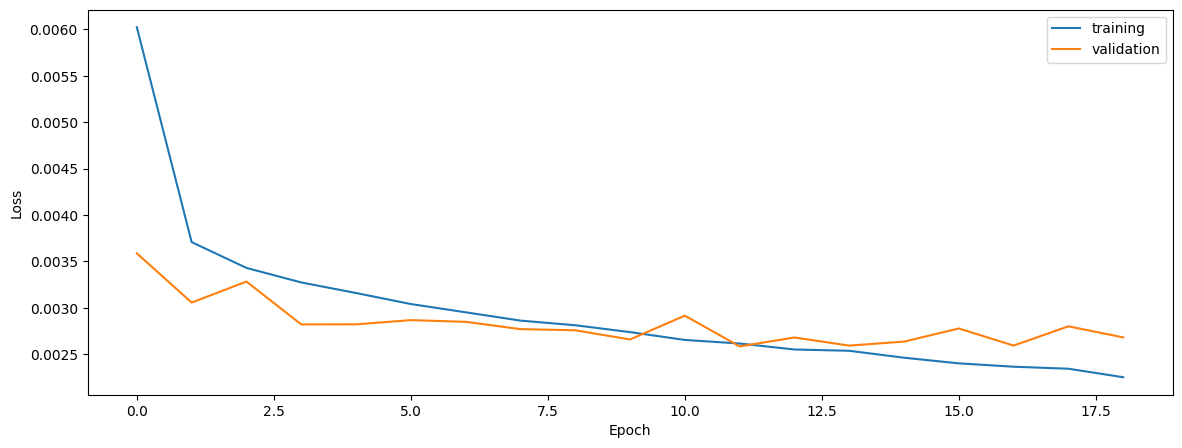

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8545990089555235
0.8379853628195589
0.8248981911784155


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8548849709052136
0.8522465462793617
0.8312876889571


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8533073065169327
0.8492589987000653
0.8284627054720595


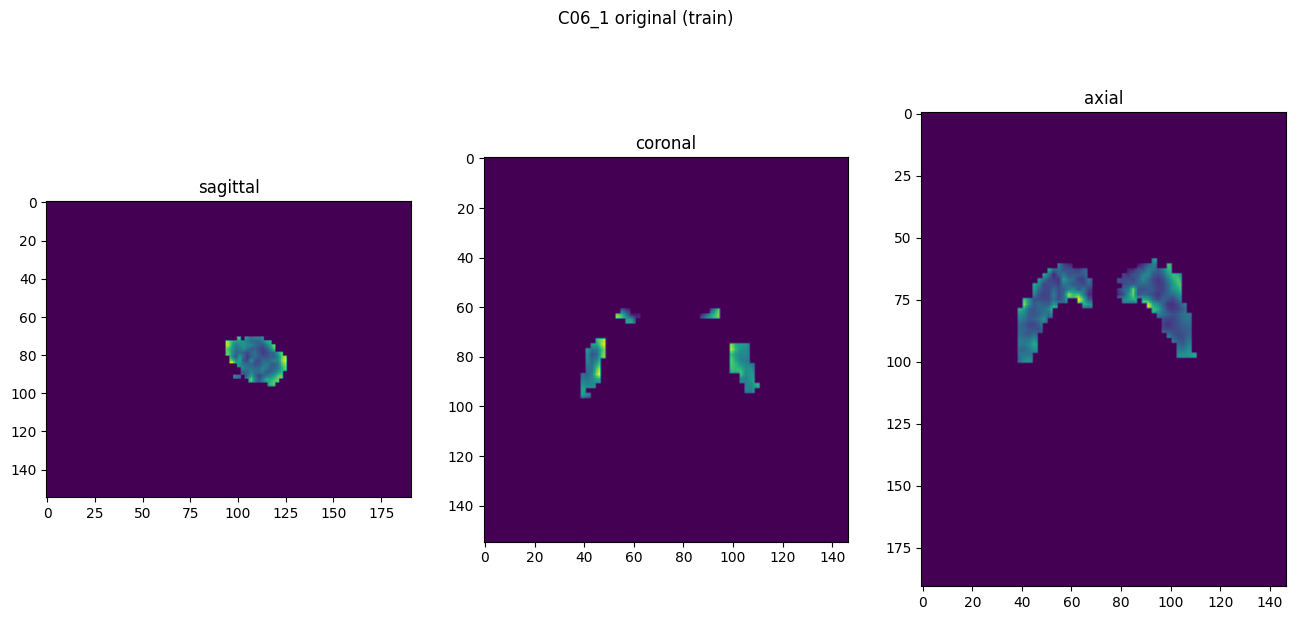

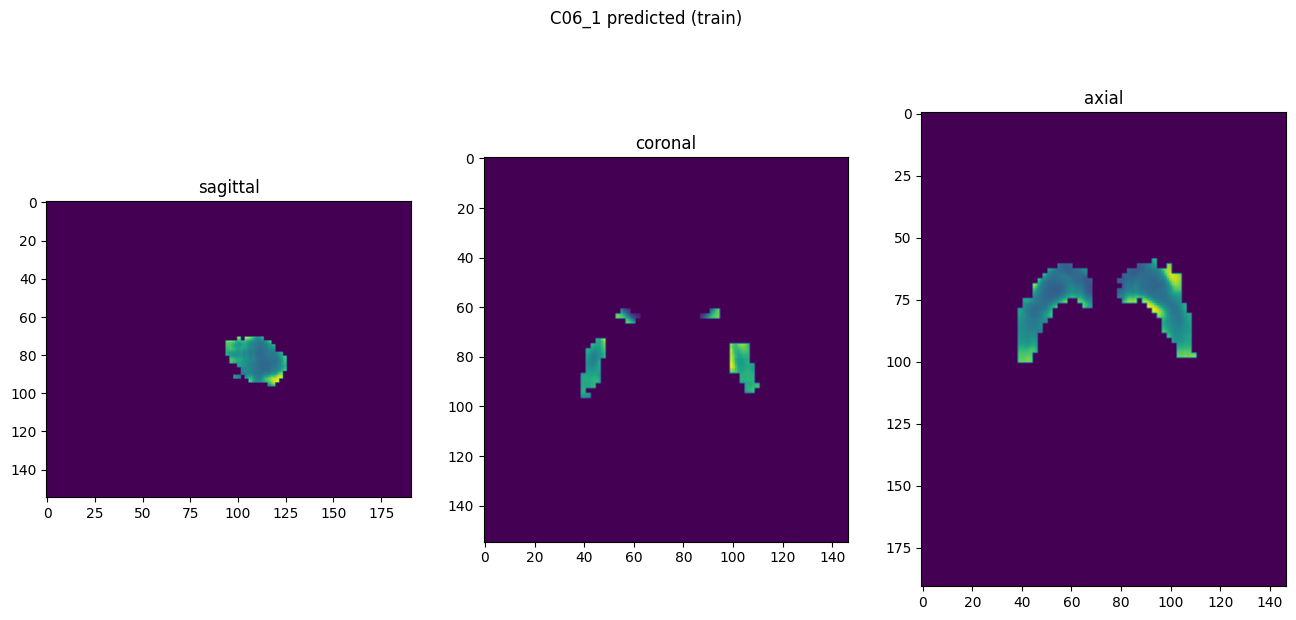

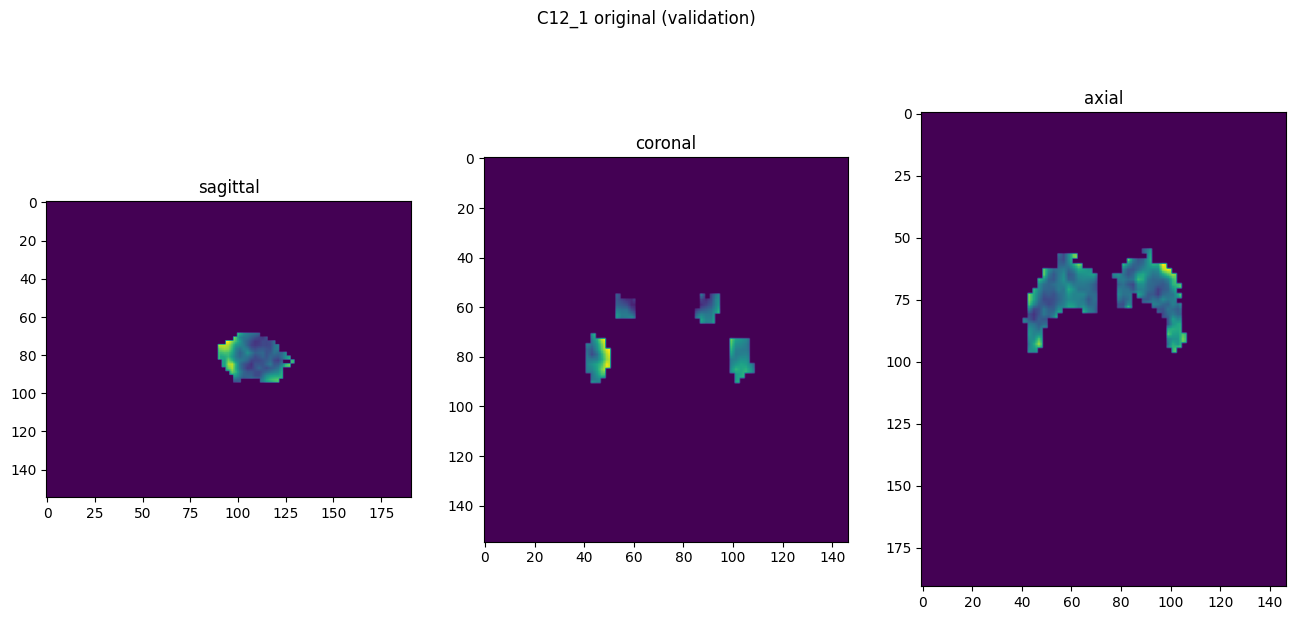

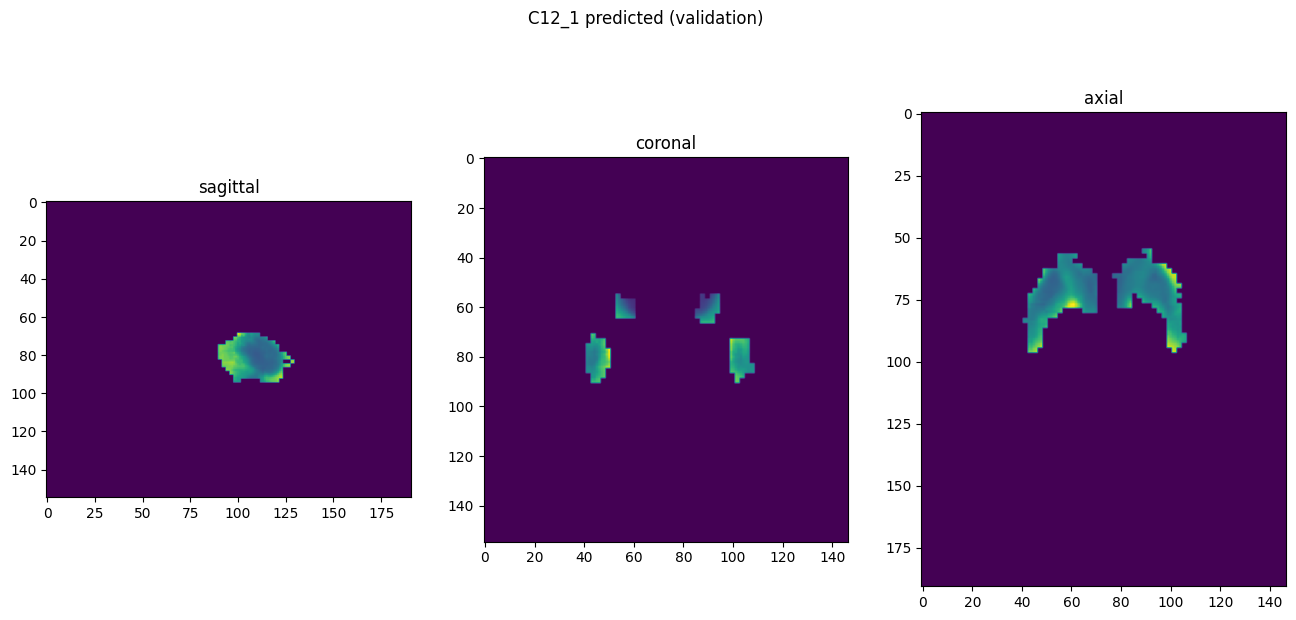

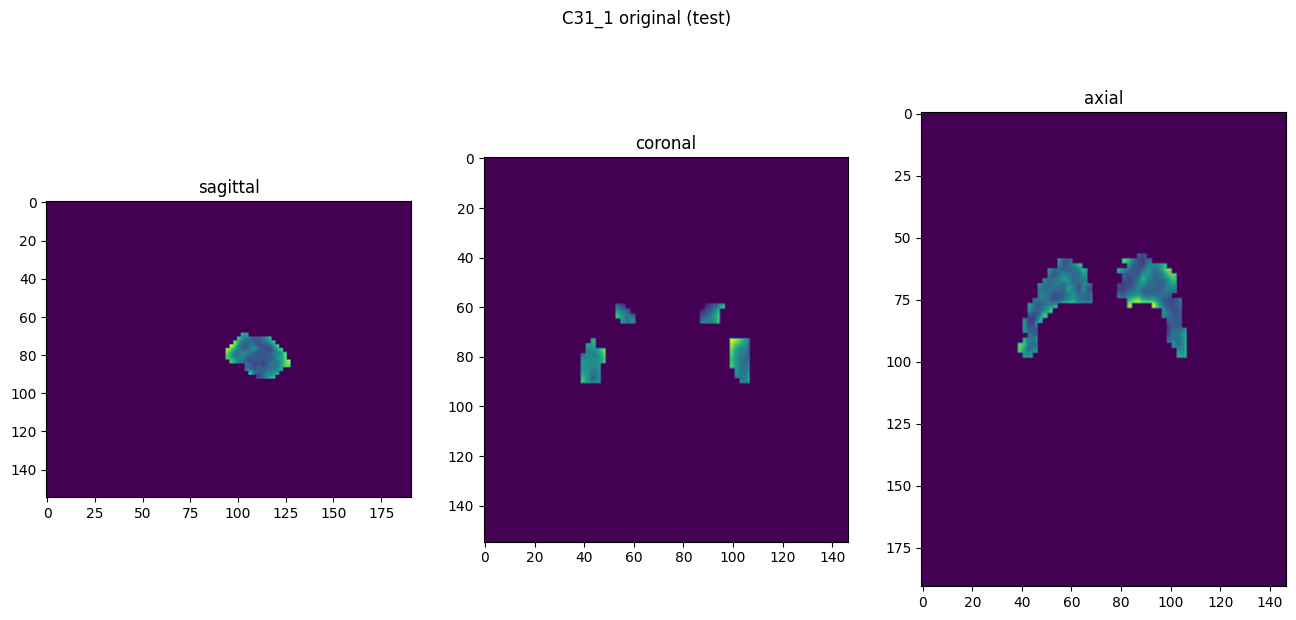

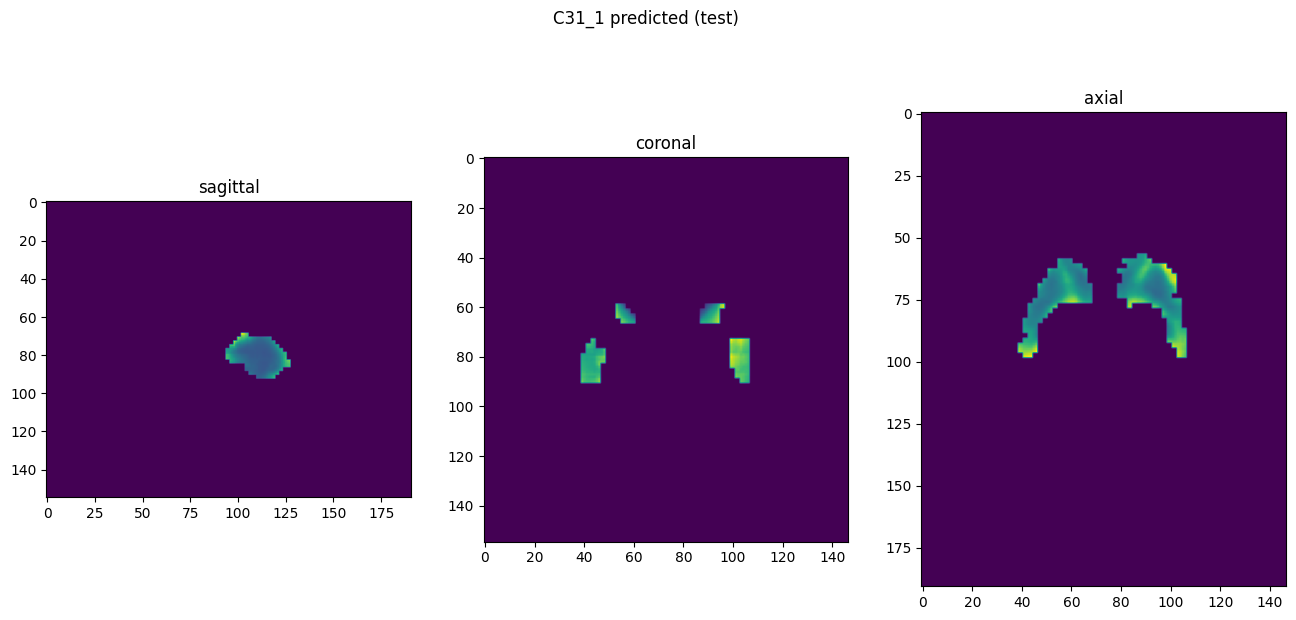

In [10]:
showResults(model, gen, threshold=None, background=False)